***
# **Small-MOCCA: MLTrees Regression Training**

***
Feature exploration, optmization and training of traditional ML models for $M_{MMO}$ estimation.  

> Programs by J.Saavedra-Bastidas.
***

In [1]:
# General Libraries ---------------------------------------------------------------------------------------------#
import os
import sys
import argparse
import yaml
import torch 

import numpy  as np
import pandas as pd
#----------------------------------------------------------------------------------------------------------------#

In [2]:
# External functions and utilities ------------------------------------------------------------------------------#
from loguru          import logger
from dataclasses     import dataclass
from datetime        import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#----------------------------------------------------------------------------------------------------------------#

In [3]:
os.chdir("../")

In [4]:
# Custom functions ----------------------------------------------------------------------------------------------#
from src.processing.features      import tabular_features
from src.optim.optimizer          import SpaceSearch, SpaceSearchConfig
from src.utils.directory          import load_yaml_dict
from src.utils.visualize          import correlation_plot, residual_plot
from src.models.mltrees.regressor import MLTreeRegressor
#----------------------------------------------------------------------------------------------------------------#

In [5]:
# Set data partition paths --------------------------------------------------------------------------------------#
train_datapath = "datasets/paperv1/moccasurvey/0_fold/train.csv"
val_datapath   = "datasets/paperv1/moccasurvey/0_fold/val.csv"
test_datapath  = "datasets/paperv1/moccasurvey/test.csv"

# Set features and targets
contfeats = ["t/t_cc", "t/t_relax", "t/t_cross", "log(t_coll)", "M_tot/M_crit", 
             "log(R_h/R_core)", "log(R_tid/R_core)",
             "log(rho(R_h))",
             "Z"]

catfeats  = ["type_sim"]
target    = ["M_MMO/M_tot"]
#----------------------------------------------------------------------------------------------------------------#

In [6]:
# Prepare the training and validation data features -------------------------------------------------------------#
train_df = pd.read_csv(train_datapath, index_col=False)
val_df   = pd.read_csv(val_datapath, index_col=False)
test_df  = pd.read_csv(test_datapath, index_col=False)

# Extract features and target
feature_names  = contfeats + catfeats + target

# Training
feats_train, feats_names = tabular_features(train_df, names=feature_names, return_names=True, onehot=True)

# Identify continuous and categorical and target columns   
cont_columns   = [col for col in feats_train.columns if col in contfeats]
cat_columns    = [col for col in feats_train.columns if any(col.startswith(cf+"_") for cf in catfeats)] 
target_columns = [col for col in feats_train.columns if col in target]

# Extract numpy arrays
X_train = feats_train[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_train = feats_train[target_columns].astype(np.float32).to_numpy().flatten()

# Validation
feats_val, _ = tabular_features(val_df, names=feature_names, return_names=True, onehot=True)

X_val = feats_val[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_val = feats_val[target_columns].astype(np.float32).to_numpy().flatten()

# Test  
feats_test, _ = tabular_features(test_df, names=feature_names, return_names=True, onehot=True)

X_test = feats_test[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_test = feats_test[target_columns].astype(np.float32).to_numpy().flatten()

print(110*"_")
print(f"- Training features (Xtrain type={type(X_train)}): {len(X_train)} [{np.shape(X_train)}]")
print(f"- Training targets  (ytrain type={type(y_train)}): {len(y_train)} [{np.shape(y_train)}]")
print(110*"_")
print(f"- Validation features (Xval type={type(X_val)}): {len(X_val)} [{np.shape(X_val)}]")
print(f"- Validation targets  (yval type={type(y_val)}): {len(y_val)} [{np.shape(y_val)}]")
print(110*"_")
print(f"- Test features (Xtest type={type(X_test)}): {len(X_test)} [{np.shape(X_test)}]")
print(f"- Test targets  (ytest type={type(y_test)}): {len(y_test)} [{np.shape(y_test)}]")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
- Training features (Xtrain type=<class 'numpy.ndarray'>): 3397124 [(3397124, 12)]
- Training targets  (ytrain type=<class 'numpy.ndarray'>): 3397124 [(3397124,)]
______________________________________________________________________________________________________________
- Validation features (Xval type=<class 'numpy.ndarray'>): 417038 [(417038, 12)]
- Validation targets  (yval type=<class 'numpy.ndarray'>): 417038 [(417038,)]
______________________________________________________________________________________________________________
- Test features (Xtest type=<class 'numpy.ndarray'>): 242159 [(242159, 12)]
- Test targets  (ytest type=<class 'numpy.ndarray'>): 242159 [(242159,)]
______________________________________________________________________________________________________________


In [7]:
from src.utils.visualize import boxplot_features_with_points

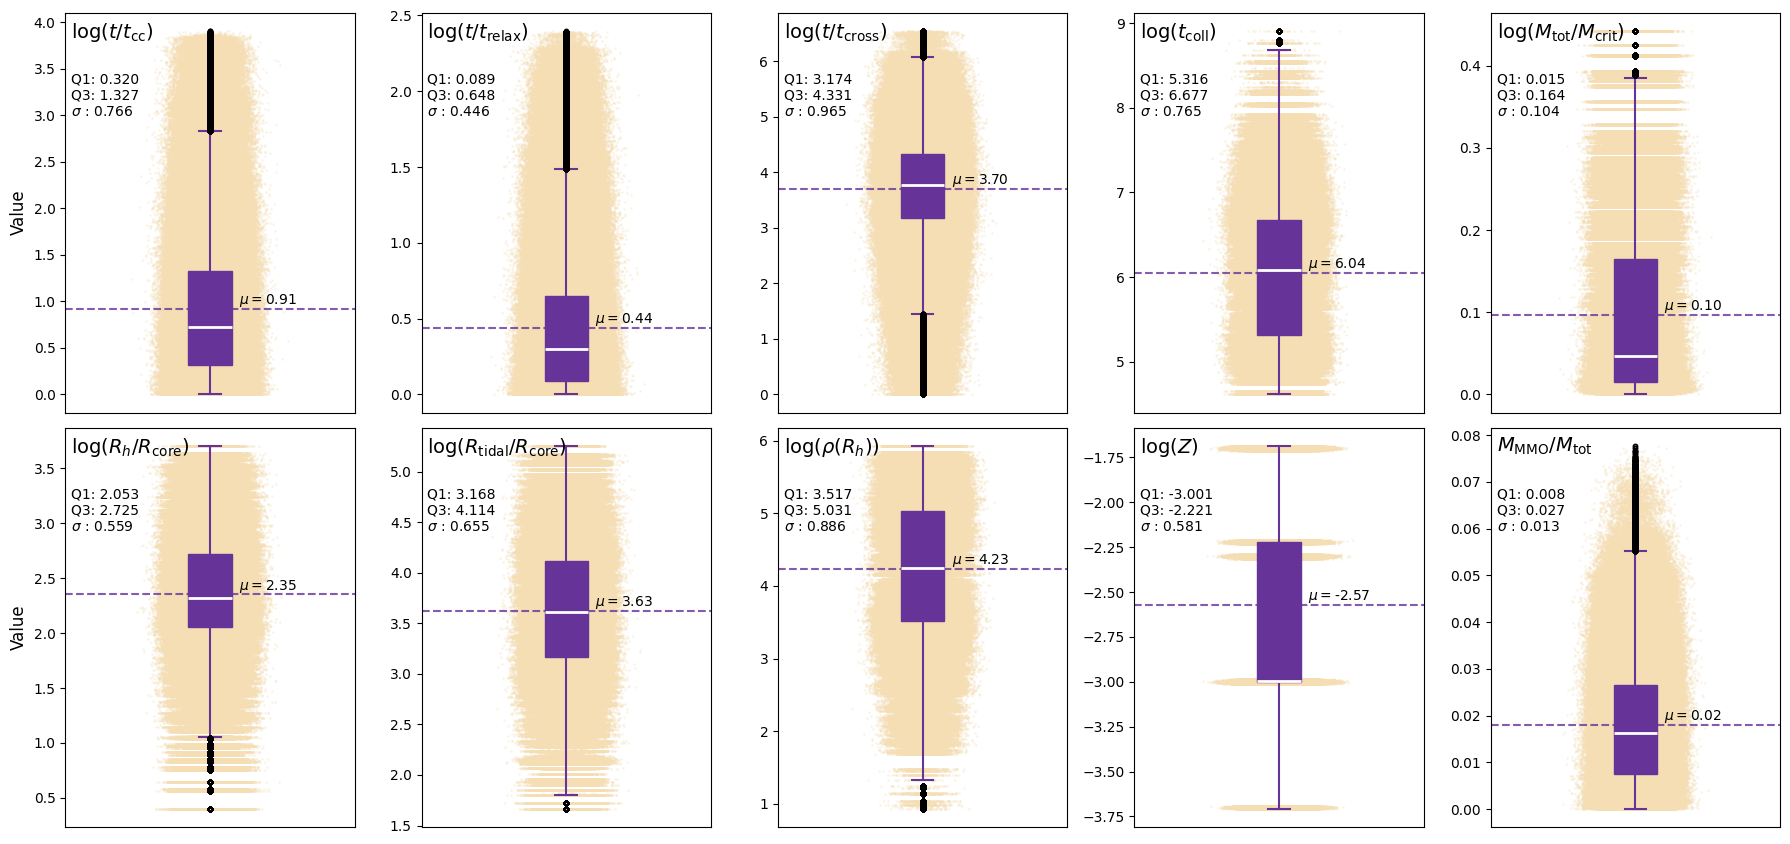

In [8]:
contvars     = cont_columns + target_columns
labels       = [feats_names[label] for label in contvars]

boxplot_features_with_points(features= feats_train[contvars], feature_names= labels,
                              path_save     = "",
                              figsize       = (18, 9),
                              name_file     = "",
                              dataset_name  = "moccasurvey",
                              nrows         = 2,
                              ncols         = 5,
                              point_color   = "wheat",
                              ifsave        = False,
                              ifshow        = True)

In [10]:
from src.utils.visualize import classic_correlogram

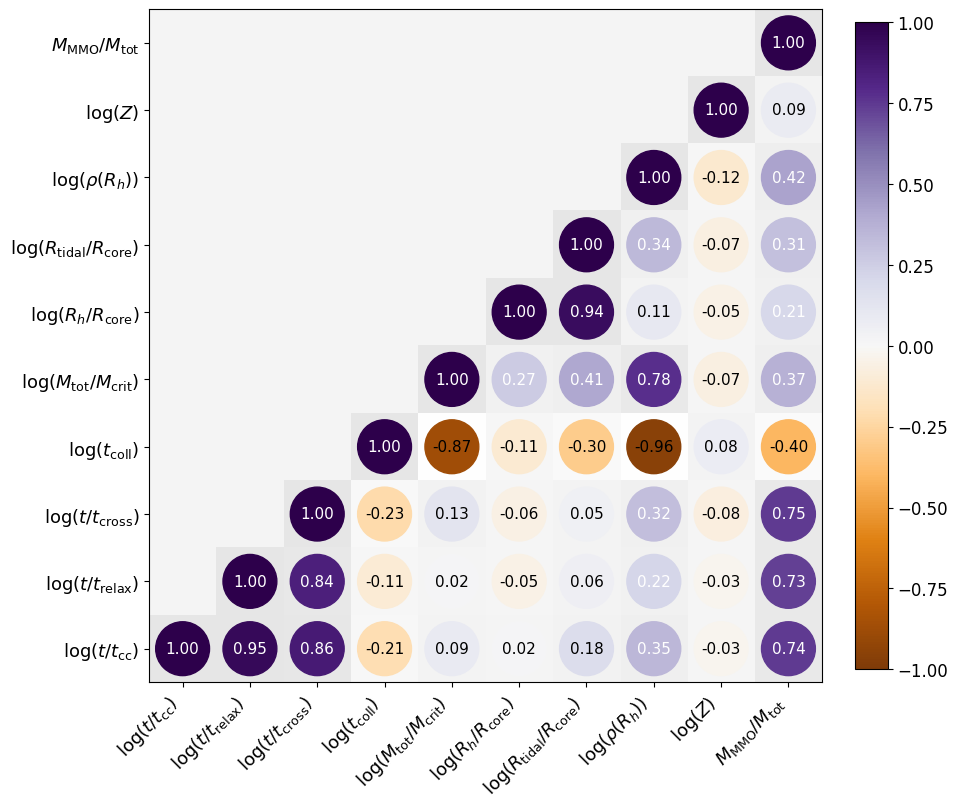

In [18]:
classic_correlogram(df=feats_train[contvars], method= "pearson", cmap= "PuOr",
                         path_save= None, name_file= None, dataset_name= None,
                         show= True, figsize= (10,10), labels=labels)

In [17]:
# Initialize optimizer with configuration
config    = SpaceSearchConfig(model_type = "xgboost", 
                              n_jobs     = 20, 
                              n_trials   = 100, 
                              device     = "cuda", 
                              seed       = 42)
optimizer = SpaceSearch(config)

# Create study name
study_name = f"spacesearch"
#----------------------------------------------------------------------------------------------------------------#

/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025-12-01 10:13:53,313 - SpaceSearch - INFO - SpaceSearch initialized for xgboost model (device=cuda)


In [18]:
save_path = f"./output/refined_exp/xgboost/"

[I 2025-12-01 10:14:02,849] A new study created in memory with name: spacesearch
[I 2025-12-01 10:14:10,273] Trial 0 finished with value: 958.2003190013019 and parameters: {'huber_slope': 1.2, 'learning_rate': 0.20218499516556748, 'num_leaves': 192, 'min_child_samples': 62, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'n_estimators': 1800, 'max_depth': 10, 'lambda_l1': 3.540362888980227, 'lambda_l2': 0.10292247147901223}. Best is trial 0 with value: 958.2003190013019.
[I 2025-12-01 10:14:15,804] Trial 1 finished with value: 999.9482000267594 and parameters: {'huber_slope': 3.0, 'learning_rate': 0.07843393422707806, 'num_leaves': 64, 'min_child_samples': 22, 'feature_fraction': 0.5100427059120604, 'bagging_fraction': 0.5825453457757226, 'bagging_freq': 6, 'n_estimators': 900, 'max_depth': 6, 'lambda_l1': 3.0592644736118975, 'lambda_l2': 0.6974693032602092}. Best is trial 0 with value: 958.2003190013019.
[I 2025-12-01 10:14:18,635] T

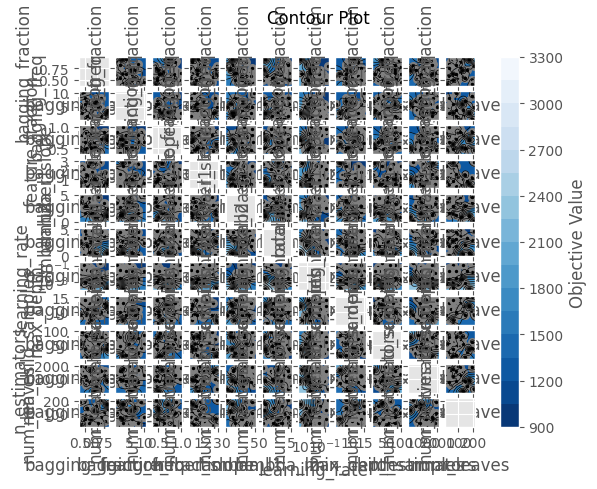

In [19]:
results = optimizer.optimize(X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, 
                             study_name     = study_name,
                             features_names = cont_columns+cat_columns,
                             output_dir     = save_path,
                             direction      = "minimize", 
                             metric         = "huber",
                             save_study     = True,
                             patience       = 20,
                             weights        = None,
                             scaler         = val_df["M_tot"])

In [20]:
model_params = results.best_params

In [21]:
model_params

{'huber_slope': 0.6000000000000001,
 'learning_rate': 0.006474708066894576,
 'num_leaves': 16,
 'min_child_samples': 44,
 'feature_fraction': 0.506693260714664,
 'bagging_fraction': 0.6017431155436215,
 'bagging_freq': 3,
 'n_estimators': 1200,
 'max_depth': 12,
 'lambda_l1': 3.6941079169162574,
 'lambda_l2': 3.7945271106270066}

In [22]:
model_params["objective"] = "reg:pseudohubererror"

In [23]:
model = MLTreeRegressor(model_type   = "xgboost",
                        device       = "cuda",
                        n_jobs       = 10,
                        model_params = model_params,
                        feat_names   = cont_columns+cat_columns,
                        verbose      = True)

train_model = model.fit(X_train = X_train, 
                        y_train = y_train, 
                        sample_weight = None)

Initializing xgboost model (device=cuda)...
Successfully initialized xgboost model
Fitting xgboost model with (3309510, 11) samples...
Successfully fitted xgboost model


In [24]:
y_pred = model.predict(X=X_val)

y_rescaled_test = y_val * (val_df["M_tot"])
y_rescaled_pred = np.clip(y_pred * (val_df["M_tot"]), 0, None)

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R2   : {r2:.4f}")

Test MSE  : 2141793.6343
Test RMSE : 1463.4868
Test MAE  : 927.6098
Test R2   : 0.9249


In [7]:
# Load previously trained model ------------------------------------------------------------------
mod_path='./output/paperv1/moccasurvey/rf/training_results_20251205_162113/'

model1 = MLTreeRegressor.load_model(path=f'{mod_path}model_fold_0.joblib', verbose=True, device='cuda')
model2 = MLTreeRegressor.load_model(path=f'{mod_path}model_fold_1.joblib', verbose=True, device='cuda')
model3 = MLTreeRegressor.load_model(path=f'{mod_path}model_fold_2.joblib', verbose=True, device='cuda')

full_models={'model1':model1,
             'model2':model2,
             'model3':model3}

Initializing rf model (device=cuda)...
Successfully initialized rf model
RandomForest model uses GPU by default (cuML)
Model loaded successfully from: ./output/paperv1/moccasurvey/rf/training_results_20251205_162113/model_fold_0.joblib
Initializing rf model (device=cuda)...
Successfully initialized rf model
RandomForest model uses GPU by default (cuML)
Model loaded successfully from: ./output/paperv1/moccasurvey/rf/training_results_20251205_162113/model_fold_1.joblib
Initializing rf model (device=cuda)...
Successfully initialized rf model
RandomForest model uses GPU by default (cuML)
Model loaded successfully from: ./output/paperv1/moccasurvey/rf/training_results_20251205_162113/model_fold_2.joblib


/opt/conda/lib/python3.11/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


In [8]:
model = full_models['model1']
y_pred      = model.predict(X=X_test)

y_rescaled_test = y_test * (test_df["M_tot"])
y_rescaled_pred = np.clip(y_pred * (test_df["M_tot"]), 0, None)

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R2   : {r2:.4f}")

Test MSE  : 2094920.6699
Test RMSE : 1447.3841
Test MAE  : 1067.2771
Test R2   : 0.9513


In [26]:
import matplotlib.pyplot as plt
from matplotlib import rcdefaults

plt.close('all')
rcdefaults()

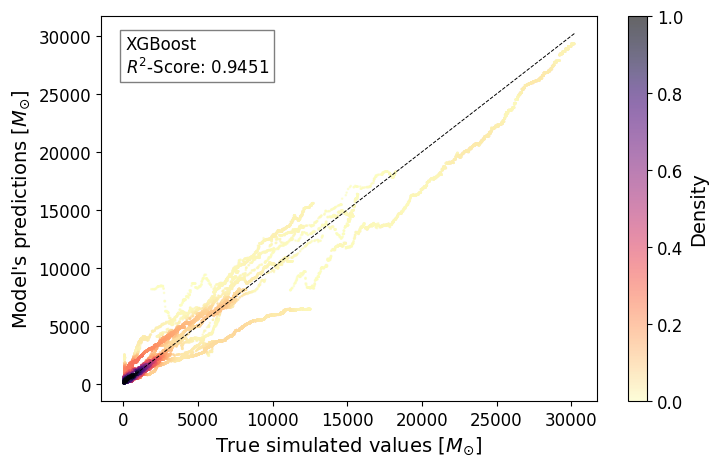

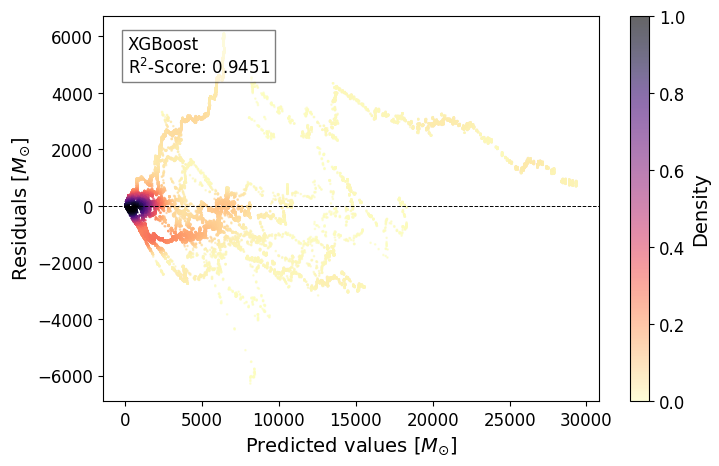

In [27]:
# Generate correlation plot

# Sampling 30% of the data
n_samples = int(len(y_test) * 0.3)
indexes   = np.random.choice(len(y_test), size=n_samples, replace=False)

correlation_plot(predictions = y_rescaled_pred.to_numpy()[indexes],
                 true_values = y_rescaled_test.to_numpy()[indexes],
                 path_save   = save_path,
                 name_file   = f"model_mean_preds_corr",
                 model_name  = f"XGBoost",
                 cmap        = "magma_r",
                 scale       = None,
                 show        = True)

# Generate residual plot
residual_plot(predictions = y_rescaled_pred.to_numpy()[indexes],
              true_values = y_rescaled_test.to_numpy()[indexes],
              path_save   = save_path,
              name_file   = f"model_mean_preds_res",
              model_name  = f"XGBoost",
              cmap        = "magma_r",
              scale       = None,
              show        = True)

In [9]:
dfs_by_sim = [group.sort_values("t").reset_index(drop=True)
              for _, group in test_df.groupby("or_sim_path")]

In [10]:
import random

idx = random.sample(range(len(dfs_by_sim)), 3)
idx=[6 , 11 , 26]
print("Simulaciones seleccionadas:", idx)

results = {}

for a in idx:
    simulation = dfs_by_sim[a]

    # ---- Compute features ----
    feats_sim, _ = tabular_features(simulation, names=feature_names,
                                    return_names=True,
                                    onehot=True)
    X_test_sim = feats_sim[cont_columns + cat_columns].astype(np.float32).to_numpy()

    # ---- Diccionario para esta simulación ----
    fchannel_codes = {0.0:"Fast", 1.0:'Slow', 2.0:"Steady"}
    sim_results = {
        'xaxis': {
            'values': simulation['t'].to_numpy(),
            'label': r'$t$ [Myr]'
        },
        'yaxis': {
            'true_values': simulation['M'].to_numpy(),
            'label': r'$M_{\rm MMO}$ [M$_\odot$]'
        },
        'iconds': {
            r'Type:': f"{fchannel_codes[simulation['type_sim'].values[0]]}"
        },
        'predictions': {}   # Aquí guardaremos cada modelo
    }

    # ---- Inferencia con cada modelo ----
    for model_name, model in full_models.items():

        y_pred = model.predict(X=X_test_sim)
        y_rescaled_pred = np.clip(
            y_pred * simulation["M_tot"], 
            0, 
            None
        )

        sim_results['predictions'][model_name] = {
            'raw_pred': y_pred,
            'rescaled_pred': y_rescaled_pred
        }

    # Guardar resultados
    results[a] = sim_results

Simulaciones seleccionadas: [6, 11, 26]


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import List, Dict


def plot_simulation_grid(
        subplot_data: List[Dict],
        n_rows: int = 1,
        n_cols: int = 3,
        figsize: tuple = (12, 4),
        save_path: str = "./figures/sim_grid.jpg",
        show: bool = True):
    """
    Creates a grid of subplots showing:
    - Ground truth curve (line)
    - Mean prediction of 3 models (scatter)
    - Shaded 1-sigma region from model-to-model variance

    Expects subplot_data entries with structure exactly matching the dict
    produced by the updated loop (xaxis, yaxis, iconds, predictions).
    """

    # Validate
    if len(subplot_data) != n_rows * n_cols:
        raise ValueError(
            f"Expected {n_rows * n_cols} dictionaries but received {len(subplot_data)}."
        )

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    # ------------------------------------------------------------------ #
    #                           LOOP PRINCIPAL                           #
    # ------------------------------------------------------------------ #
    counter=0
    for ax, data in zip(axes, subplot_data):

        # -----------------------------
        #   EXTRACT TRUE VALUES
        # -----------------------------
        x = data["xaxis"]["values"]
        y_true = data["yaxis"]["true_values"]

        # -----------------------------
        #   EXTRAER PREDICCIONES DE LOS 3 MODELOS
        # -----------------------------
        predictions_dict = data["predictions"]

        preds = []
        for model_name, model_dict in predictions_dict.items():
            preds.append(model_dict["rescaled_pred"])

        preds = np.array(preds)     # (3, T)

        # Promedio y desviación estándar
        y_pred_mean = preds.mean(axis=0)
        y_pred_std = preds.std(axis=0)

        # -----------------------------
        #   PLOT
        # -----------------------------

        # Ground truth (línea)
        ax.plot(
            x, y_true,
            lw=1.5, color="black", ls="dashed",
            label="Ground truth"
        )

        # Banda de incertidumbre
        ax.fill_between(
            x,
            y_pred_mean - y_pred_std,
            y_pred_mean + y_pred_std,
            color="maroon",
            alpha=0.25,
            label="±1σ"
        )

        # Media de las predicciones
        ax.scatter(
            x, y_pred_mean,
            s=6, color="maroon", marker='o',
            label="Mean ML predictions"
        )

        # Initial conditions box
        text_dict = data.get("iconds", {})
        if text_dict:
            text_lines = []
            for k, v in text_dict.items():
                if isinstance(v, float):
                    text_lines.append(f"{k}= {v:.3e}")
                else:
                    ax.set_title(f'{k} {v}', loc='left')


        # Axis labels
        ax.set_xlabel(data["xaxis"]["label"], fontsize=12)
        if counter== 0: ax.set_ylabel(data["yaxis"]["label"], fontsize=12)
        ax.set_yscale('log')

        ax.legend(loc='lower right')
        counter +=1

    # ------------------------------------------------------------------ #
    #                             SAVE FIGURE                            #
    # ------------------------------------------------------------------ #

    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    plt.tight_layout()

    try:
        plt.savefig(save_path, dpi=500)
        if show:
            plt.show()
    except Exception as e:
        raise RuntimeError(f"Failed to save or display plot: {e}")
    finally:
        plt.close(fig)

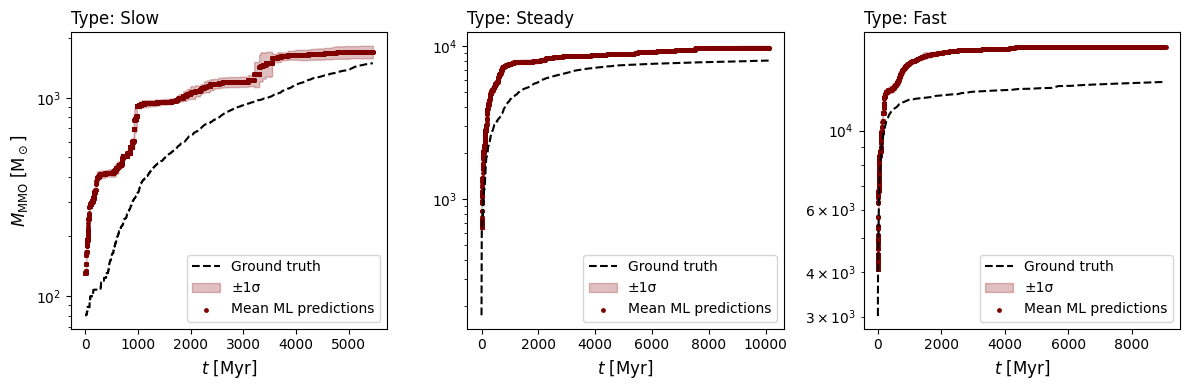

In [12]:
subplot_data = [results[i] for i in idx]
plot_simulation_grid(subplot_data)

In [13]:
import matplotlib.pyplot as plt

In [15]:
# Young Massive Clusters (Vergara, et al, 2025) -----------------------------------------------------------------#
files = ["BH_mass_cluster1",
         "BH_mass_cluster2",
         "BH_mass_cluster3",
         "BH_mass_cluster4",
         "BH_mass_cluster5",
         "BH_mass_cluster6"]

iconds_df = pd.read_csv("./rawdata/ymcs/V2025/data_V25ab.dat",
                        sep="\s+",
                        header=0)
evol_dfs = []

for file in files:

    df = pd.read_csv(f"./rawdata/ymcs/V2025/{file}.dat",              
                     sep="\s+",
                     header=None,            
                     names=["t[Myrs]", "M_MMO[Msun]"])
    evol_dfs.append(df)
#----------------------------------------------------------------------------------------------------------------#

In [16]:
iconds_df

,Name,R_h(pc),R_c(pc),M(Msun),N,m(Msun),M_max(Msun),tau(Myr),sigma2(km/s),sigma(pc/Myr),r_star(pc),t_cross(Myr),t_relax(Myr),t_coll(Myr),t_cc(Myr),M_crit(Msun)
0,Cluster1,0.100,0.049326,586000.0,1000000.0,0.58,148.49,5.00,142.04,145.27,1.0,0.000688,4.982700,470.5800,0.064226,12042000.0
1,Cluster2,0.050,0.024663,438000.0,750000.0,0.58,149.34,3.87,173.05,176.98,1.0,0.000283,1.566300,83.9840,0.020075,3392200.0
2,Cluster3,0.050,0.024663,293000.0,500000.0,0.58,149.34,3.79,142.04,145.27,1.0,0.000344,1.311500,117.6500,0.016809,2874200.0
3,Cluster4,0.010,0.004933,146000.0,250000.0,0.58,143.68,3.65,224.06,229.15,1.0,0.000044,0.087775,2.1032,0.001169,100640.0
4,Cluster5,0.010,0.004933,58000.0,100000.0,0.58,149.89,3.83,142.04,145.27,1.0,0.000069,0.059793,4.7301,0.000764,66764.0
5,Cluster6,0.005,0.002466,28000.0,50000.0,0.58,143.68,3.71,141.04,144.24,1.0,0.000035,0.016019,1.1912,0.000213,13440.0


In [17]:
from src.utils.phyfactors import rho_at_rh

In [18]:
# Creating cluster 1 - model comparison -------------------------------------------------------------------------#
index_num      = 0      
df_cluster     = evol_dfs[index_num].copy()
iconds_cluster = iconds_df.iloc[index_num]

# Continous input features
df_cluster["t/t_cc"]               = np.log10(df_cluster["t[Myrs]"]/iconds_cluster["t_cc(Myr)"]+1)
df_cluster["t/t_relax"]            = np.log10(df_cluster["t[Myrs]"]/iconds_cluster["t_relax(Myr)"]+1)
df_cluster["t/t_cross"]            = np.log10(df_cluster["t[Myrs]"]/iconds_cluster["t_cross(Myr)"]+1)
df_cluster["log(t_coll)"]          = np.log10(iconds_cluster["t_coll(Myr)"]+1)
df_cluster["M_tot/M_crit"]         = np.log10(iconds_cluster["M(Msun)"]/iconds_cluster["M_crit(Msun)"]+1)
df_cluster["log(rho(R_h))"]        = np.log10(rho_at_rh(n_stars   = iconds_cluster["N"], 
                                                        hm_radius = iconds_cluster["R_h(pc)"])[0][0]+1)
df_cluster["log(R_h/R_core)"]      = np.log10(iconds_cluster["R_h(pc)"]/iconds_cluster["R_c(pc)"] +1)
df_cluster["log(R_tid/R_core)"]    = np.log10(iconds_cluster["R_h(pc)"]*5/iconds_cluster["R_c(pc)"] +1)

df_cluster["Z"]                    = np.log10(0.01)
df_cluster["fracbin"]              = 0.0

# Categorical features
df_cluster["type_sim_0.0"] = True
df_cluster["type_sim_1.0"] = False
df_cluster["type_sim_2.0"] = False

# Target 
df_cluster["M_MMO/M_tot"] = df_cluster["M_MMO[Msun]"]/ (iconds_cluster["M(Msun)"])

In [19]:
X_feats = df_cluster[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_true  = df_cluster[target_columns].astype(np.float32).to_numpy().flatten()

In [20]:
y_pred  = model.predict(X=X_feats)

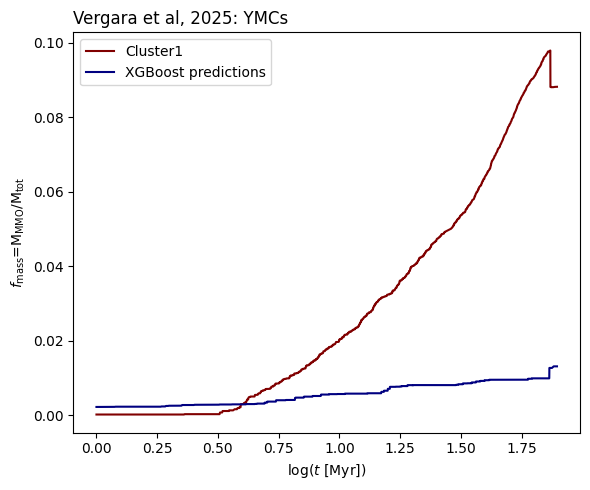

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))
colors  = ["maroon",
           "darkgoldenrod",
           "olive",
           "teal",
           "magenta",
           "navy"]
    
time = X_feats[:,0]
mass = y_true

ax.plot(time, mass, label=f'{iconds_df["Name"][index_num]}', color=colors[0])

time = X_feats[:,0]
mass = y_pred

ax.plot(time, mass, label=f'XGBoost predictions', color=colors[-1])

ax.set_xlabel("log($t$ [Myr])")
ax.set_ylabel(r"$f_{\rm{mass}}$=M$_{\rm{MMO}}$/M$_{\rm{tot}}$")
ax.set_title("Vergara et al, 2025: YMCs", loc="left")
ax.legend()

fig.tight_layout()
#plt.savefig("./figures/ymcs/mass_vs_time.jpg", bbox_inches="tight", dpi=900)
plt.show()